In [1]:
from fastai.vision.all import *
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [2]:
dest_path = "/home/jupyter/data/"
path = Path("{}egyptian_fruit_bat_annotated_tiny_cqt".format(dest_path))
files = [str(x) for x in get_image_files(path)]

print("Found {} squeaks!".format(len(files)))
files[0]

Found 8224 squeaks!


'/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files210/121220010548932125.png'

In [28]:
annot_path = "{}/egyptian_fruit_bat_annotated_tiny/better_annotations.csv".format(dest_path)

def format_annotations(annot_path):
    annotations = pd.read_csv(annot_path)
    context_dict = {0:"unknown", 1:"separation", 2:"biting", 
                    3:"feeding", 4:"fighting", 5:"grooming", 
                    6:"isolation", 7:"kissing", 8:"landing", 
                    9:"mating protest", 10:"threat-like", 
                    11:"general", 12:"sleeping"}

#     annotations = annotations_full.loc[:,["File name", "File folder", "Context"]]
    annotations["Context desc."] = [context_dict[x] for x in annotations["Context"]]
    annotations["File name"] = [x.replace(".WAV", ".png") for x in annotations["File name"] ]
    annotations["File path"] = ["{}/{}/{}".format(str(path),
                                                  str(annotations['File folder'][i]), 
                                                  str(annotations['File name'][i])) for i in annotations.index]
    annotations = annotations[annotations["File path"].isin(files)]
    annotations = annotations.drop_duplicates(subset = ['File path'])
    return annotations


annotations = format_annotations(annot_path)
#make it so we only study these labels for context:
yossi_labels = ['feeding', 'mating protest', 'sleeping', 'threat-like']
annotations = annotations.loc[annotations['Context desc.'].isin(yossi_labels)]

annotations.head()

,Unnamed: 0,FileID,Emitter,Addressee,Context,Emitter pre-vocalization action,Addressee pre-vocalization action,Emitter post-vocalization action,Addressee post-vocalization action,Start sample,End sample,File name,File folder,Context desc.,File path
23,23,133,0,0,12,0,0,0,0,208415,484176,120601041134496318.png,files101,sleeping,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files101/120601041134496318.png
54,54,259,0,0,12,0,0,0,0,1,615248,120601163203025371.png,files101,sleeping,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files101/120601163203025371.png
118,118,1333,0,0,12,0,0,0,0,1,664400,120603011026138518.png,files101,sleeping,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files101/120603011026138518.png
209,209,1775,-118,0,3,2,2,3,3,1,729936,120603212856476452.png,files101,feeding,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files101/120603212856476452.png
221,221,1803,0,0,3,0,0,0,0,1,426832,120603215836829478.png,files101,feeding,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files101/120603215836829478.png


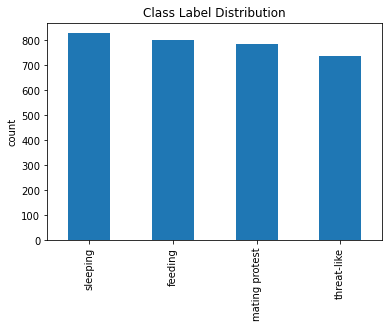

In [4]:
annotations['Context desc.'].value_counts().plot(kind = 'bar', title = "Class Label Distribution", ylabel = "count")
plt.show()

In [5]:
def get_x(p):
    #returns a gs numpy array
    return  np.array(Image.open(p))[:, :, 0]

def pos_enc2d_np(gs_im, out_c = 5, eta = 0.05):
    def constrain(x, a, b):
        if x > b: return b
        if x < a: return a
        else: return x

    def make_mask(shape, start, end):
        #returns a vertical mask:
        block_0 = np.zeros((shape[1], start))
        block_1 = np.ones((shape[1], end - start))
        block_2 = np.zeros((shape[1], constrain(shape[0] - end, 0, shape[0])))
        mask = np.block([block_0, block_1, block_2])
        
        if mask.shape != shape:
            return mask[:shape[1], :shape[1]]
        else: return mask

    window_widths = np.random.uniform(float(1/(out_c-1.5)) - eta, 
                                      float(1/(out_c-1.5)) + eta, out_c)
    window_widths = np.round(window_widths*gs_im.shape[0]).astype(int)   
    
    window_starts = np.random.uniform(float(1/out_c) - eta, 
                                      float(1/out_c) + eta, out_c)
    
    window_starts = np.array([sum(window_starts[0:i]) for i in range(out_c)])
    window_starts = np.round(window_starts*gs_im.shape[0]).astype(int)   
    new_ims = []
    
    for i in range(out_c):
        if i < out_c:
            temp_mask = make_mask(gs_im.shape, 
                                  start = window_starts[i], 
                                  end = window_starts[i] + window_widths[i])
        if i == out_c:
            #making sure the last mask gets the last of the image:
            temp_mask = make_mask(gs_im.shape, 
                                  start = int(gs_im.shape[0]*out_c), 
                                  end = gs_im.shape[0])

        new_ims.append(np.multiply(temp_mask, gs_im))
    return np.dstack(new_ims) 

def pos_enc2d_layer(tensor, out_c = 6, eta = 0.05):
    #adapting the pos_enc2d to act as a layer in the model:
    bs, channels, h, w = tensor.shape
    assert channels == 1, "Input should have one channel!"
    np_tensor = np.array(tensor.cpu()) #a little hacky! probably could be better!
    stack = [pos_enc2d_np(np_tensor[i,:, :, :].reshape(h, w), out_c, eta) for i in range(bs)]
    stack  = np.array(stack).reshape(bs, out_c, h, w)
    return torch.from_numpy(stack).type(torch.cuda.FloatTensor)

def get_y(p, annotations = annotations):
    return annotations.loc[annotations['File path'] == p]['Context desc.'].values[0]

def get_items(p, annotations = annotations):
    temp_files = [str(x) for x in get_image_files(path)]
    return annotations.loc[annotations['File path'].isin(temp_files)]['File path'].values



In [6]:
class res_model(Module):    
    def __init__(self, n_enc_layers = 5):
        super().__init__()
        
        self.with_pos_enc = n_enc_layers != 1
        self.in_c = (1, n_enc_layers)[self.with_pos_enc]
        self.encoder_head = nn.Sequential(
                                    nn.Conv2d(in_channels = self.in_c,     
                                             out_channels = 3, 
                                             kernel_size = (5, 5), 
                                             stride = (1, 1), 
                                             padding = (1, 1), 
                                             bias = True),
                                    nn.ReLU(inplace = True))
        
        self.res_block = resnet18()
        
    def forward(self, x):
        if self.with_pos_enc:
            x = pos_enc2d_layer(x, out_c = self.in_c)
        x = self.encoder_head(x)
        return self.res_block(x)

In [7]:
class NoOverfittingCB(Callback):
    def __init__(self, 
                 patience = 3, 
                 min_delta = 0.01, 
                 reset_on_fit = True):
        self.patience, self.min_delta, self.reset_on_fit, self.wait = patience, min_delta, reset_on_fit, 0
    
    def before_fit(self):
        self.run = not hasattr(self, "lr_finder") and not hasattr(self, "gather_preds")
        if self.reset_on_fit is None: self.best = float("inf")
        self.vidx = list(self.recorder.metric_names[1:]).index("valid_loss")
        self.lidx = list(self.recorder.metric_names[1:]).index("train_loss")
    
    def after_epoch(self):
        vval = self.recorder.values[-1][self.vidx]
        tval = self.recorder.values[-1][self.lidx]
        
        diff = tval - vval + self.min_delta
        
        if diff < 0:
            self.wait += 1
        else:
            self.wait = 0
        if self.wait >= self.patience:
                print("Fit cancelled due to overfitting...")
                raise CancelFitException() 
    
    def after_fit(self): 
        self.run = True
        
        

In [8]:
def get_random_dls():
    return DataBlock(blocks = (ImageBlock, CategoryBlock), 
               get_items = get_items, 
               get_x = get_x, 
               get_y = get_y, 
               splitter = RandomSplitter(seed = 42)).dataloaders(path, 
                                                                 bs = 32)
def get_learner_with_c(c, dls):
    learn = Learner(dls, res_model(n_enc_layers = c), 
                    metrics = accuracy,
                    cbs=[EarlyStoppingCallback(monitor='valid_loss', 
                                               min_delta=0.1, 
                                               patience=5),
                         NoOverfittingCB()])
    learn.unfreeze()
    return learn

In [9]:
c_range = list(range(1, 6))
valid_acc_scores = []
valid_bce_scores = []
n_samps_per_c = 20
max_acc = 0
best_learner = None

In [15]:
%%capture
for c in c_range:
    for i in range(n_samps_per_c):
        temp_dls = get_random_dls()
        temp_learner = get_learner_with_c(c, temp_dls)
        temp_learner.fit_one_cycle(15, 5e-4)
        temp_valid = list(temp_learner.validate())
        valid_acc_scores.append([c, temp_valid[1]])
        valid_bce_scores.append([c, temp_valid[0]])
        
        if temp_valid[1]>max_acc:
            max_acc = temp_valid[1]
            mest_learner = temp_learner
            
        del temp_dls; del temp_learner; del temp_valid;

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [16]:
valid_acc_scores = np.array(valid_acc_scores)
valid_bce_scores = np.array(valid_bce_scores)

In [17]:
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm

def ridgeline(data,
              x_vals,
              overlap=0, 
              labels=None, 
              n_points=150):
    
    xx = np.linspace(np.min(np.concatenate(data)),
                     np.max(np.concatenate(data)), n_points)
    curves = []
    ys = []
    for i, d in enumerate(data):
        pdf = gaussian_kde(d)
        y = i*(1.0-overlap)
        ys.append(y)
        curve = pdf(xx)
        plt.plot((curve)/(np.max(curve)*3) + x_vals[i], xx, 
                 c='k', zorder=len(data)-i+1)
    plt.xticks(x_vals)
    
    if labels:
        plt.yticks(ys, labels)

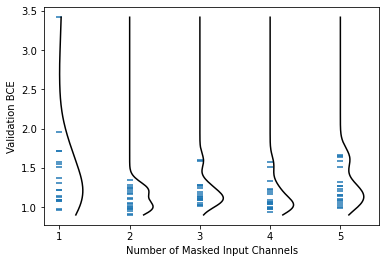

In [18]:
ridgeline_data = []
for c in c_range:
    c_mask = valid_bce_scores[:, 0] == c
    if sum(c_mask) != 0:
        ridgeline_data.append(valid_bce_scores[c_mask][:, 1])
ridgeline_data = np.array(ridgeline_data)

ridgeline(ridgeline_data, x_vals = c_range)
plt.scatter(valid_bce_scores[:, 0], 
            valid_bce_scores[:, 1], marker = "_")
plt.xlabel("Number of Masked Input Channels")
plt.ylabel("Validation BCE")
plt.xticks(c_range)
plt.show()

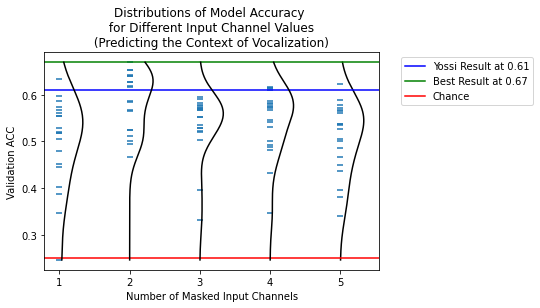

In [33]:
ridgeline_data = []
for c in c_range:
    c_mask = valid_acc_scores[:, 0] == c
    if sum(c_mask) != 0:
        ridgeline_data.append(valid_acc_scores[c_mask][:, 1])
ridgeline_data = np.array(ridgeline_data)

ridgeline(ridgeline_data, x_vals = c_range)
plt.scatter(valid_acc_scores[:, 0], 
            valid_acc_scores[:, 1], marker = "_")
plt.xlabel("Number of Masked Input Channels")
plt.axhline(0.61, 
            label = "Yossi Result at 0.61", 
            c = "b")
plt.axhline(np.max(ridgeline_data), 
            label = "Best Result at {}".format(np.max(ridgeline_data).round(decimals = 3)), 
            c = "g")
plt.axhline(0.25, 
            label = "Chance", 
            c = "r")
plt.ylabel("Validation ACC")
plt.xticks(c_range)
plt.legend(loc = 'upper left', 
          bbox_to_anchor=(1.05, 1))
plt.title("Distributions of Model Accuracy \n for Different Input Channel Values \n (Predicting the Context of Vocalization) ")
plt.show()